In [ ]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/My Drive/project_data/train_data.csv')
data = train_data.copy()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
feature_description = pd.read_excel('/content/drive/My Drive/project_data/data_dictionary.xlsx')
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [ ]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data

In [ ]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)

In [ ]:
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)

In [ ]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
            
    return df[non_cate]

In [ ]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical3 = numerical.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

mice_imp_x = imp.fit_transform(numerical3, y = y_train)
mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [ ]:
from sklearn import preprocessing

def stadardize(X):
  scaler = preprocessing.StandardScaler().fit(X)
  X = scaler.transform(X)
  return X

In [ ]:
mice_imp_x = stadardize(mice_imp_x)

mice_imp_x_test = stadardize(mice_imp_x_test)

### Baseline Keras

In [ ]:
from keras import metrics
from keras.optimizers import Adam

In [ ]:
def ANN(n_input):
  model = Sequential()
  model.add(Dense(20, input_dim = n_input, activation= 'relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation= 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = [metrics.AUC()])
  return model


In [ ]:
from sklearn.metrics import roc_auc_score

n_input = mice_imp_x.shape[1]
model = ANN(n_input)
history = model.fit(mice_imp_x, y_train, class_weight= 'balanced', epochs= 20, verbose=2)
# evaluate model
pred = model.predict(mice_imp_x_test)
score = roc_auc_score(y_test, pred)
print('ROC AUC: %.3f' % score)

Epoch 1/20
 - 172s - loss: 0.1357 - auc_2: 0.9259
Epoch 2/20
 - 173s - loss: 0.1086 - auc_2: 0.9439
Epoch 3/20
 - 175s - loss: 0.1047 - auc_2: 0.9472
Epoch 4/20
 - 173s - loss: 0.1030 - auc_2: 0.9488
Epoch 5/20
 - 172s - loss: 0.1020 - auc_2: 0.9498
Epoch 6/20
 - 169s - loss: 0.1013 - auc_2: 0.9504
Epoch 7/20
 - 168s - loss: 0.1010 - auc_2: 0.9508
Epoch 8/20
 - 171s - loss: 0.1001 - auc_2: 0.9515
Epoch 9/20
 - 172s - loss: 0.0996 - auc_2: 0.9517
Epoch 10/20
 - 173s - loss: 0.0991 - auc_2: 0.9523
Epoch 11/20
 - 172s - loss: 0.0990 - auc_2: 0.9525
Epoch 12/20
 - 171s - loss: 0.0986 - auc_2: 0.9527
Epoch 13/20
 - 169s - loss: 0.0982 - auc_2: 0.9530
Epoch 14/20
 - 170s - loss: 0.0979 - auc_2: 0.9534
Epoch 15/20
 - 168s - loss: 0.0975 - auc_2: 0.9535
Epoch 16/20
 - 168s - loss: 0.0973 - auc_2: 0.9537
Epoch 17/20
 - 167s - loss: 0.0971 - auc_2: 0.9538
Epoch 18/20
 - 167s - loss: 0.0968 - auc_2: 0.9540
Epoch 19/20
 - 169s - loss: 0.0968 - auc_2: 0.9542
Epoch 20/20
 - 170s - loss: 0.0965 - auc

In [ ]:
score = roc_auc_score(y_test, pred)
print('ROC AUC: %.3f' % score)

ROC AUC: 0.952


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)


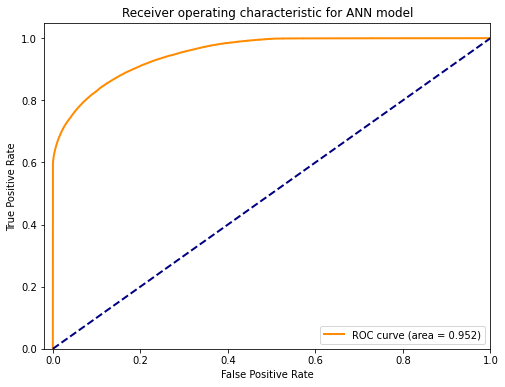

In [ ]:
plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for ANN model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def pred_convert(pred, threshold):

  result = np.array([0 for _ in range(len(pred))])
  result[pred.flatten() > threshold] = 1
  return result


In [ ]:
from numpy import arange
threshold = arange(0, 1, 0.01)
auc_dict = {}
for x in threshold:
  y_hat = pred_convert(pred, x)
  auc_dict[x] = roc_auc_score(y_test, y_hat)

auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[1], reverse = True)}

In [ ]:
gmeans = (tpr * (1-fpr))** 0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.066400, G-Mean=0.866


In [ ]:
print('The best threshold is 0.07, where the correponding auc is {}'.format(auc_dict[0.07]))

The best threshold is 0.07, where the correponding auc is 0.8656222551265395


In [ ]:
label = pred_convert(pred, 0.07)
fpr, tpr, _ = roc_curve(y_test, label)
auc(fpr, tpr)

0.8656222551265395

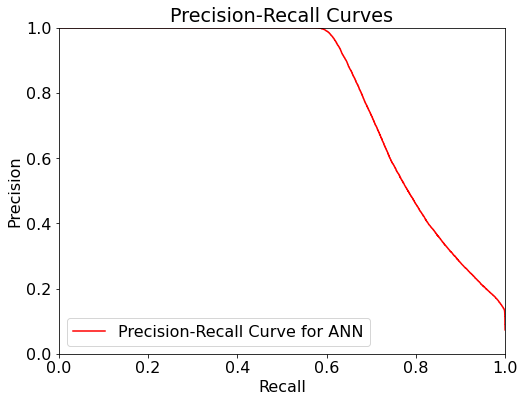

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, pred)



plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(recall, precision, 'r', label='Precision-Recall Curve for ANN')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()

Normalized confusion matrix
[[0.88736813 0.11263187]
 [0.15612362 0.84387638]]


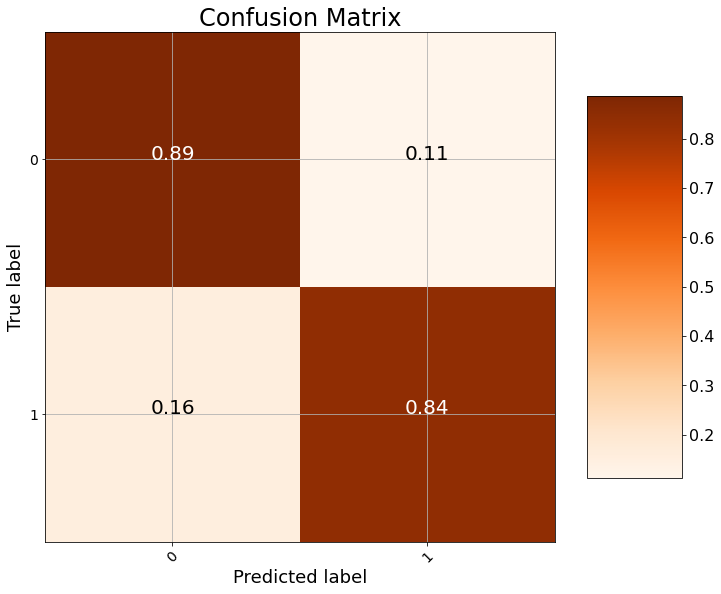

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, label)
plot_confusion_matrix(cm, classes = ['0', '1'], normalize = True, 
                      title = 'Confusion Matrix')
